# Section 10

Today we'll go through constructing indexes of variables in more detail (to resolve any confusion from last week), as well as creating nice regression tables and graphs using `stargazer` and `ggplot2`, using Aya, Kritika and Princy's project as an example. Recall they are interested in the relationship between mental health and participation in communal activities in Indonesia, using data from IFLS Round 5.

In [4]:
# Load necessary packages
pacman::p_load(tidyverse, stargazer, dplyr, haven, stringr, ggplot2,factoextra, lfe)

Snapshot of community participation questionnaire

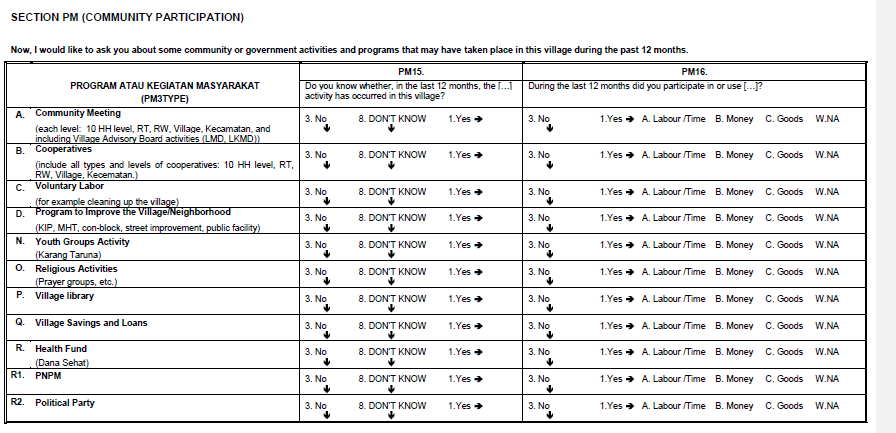

In [5]:
# Data on individual level community paritcipation
pm2 <- read_dta('./b3b_pm2.dta')

In [6]:
# Create number of activities participated in (with either time, cash or goods) and number activities spent time on
pm <- pm2 %>% group_by(hhid14_9, pid14) %>% summarise(activities = sum(pm16==1,na.rm = T), spent_time = sum(str_detect(pm16_b,"A"), na.rm = 1))

`summarise()` has grouped output by 'hhid14_9'. You can override using the
`.groups` argument.


Snapshot of mental health questionnaire

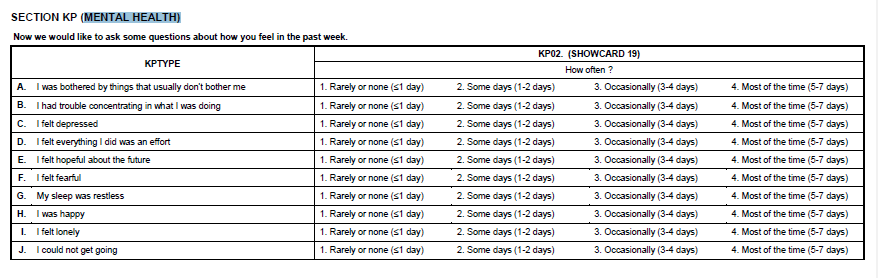

In [7]:
# Read data frame on mental health and pivot wide
kp <- read_dta('./b3b_kp.dta') %>% pivot_wider(names_from = kptype, values_from = kp02) 

We want all of the variables in our index to point in the same qualitative direction. Here, eveything except columns E and H have higher numbers associated with worse mental health so let's flip them. 

In [8]:
# Make everything same direction (higher number = more days depressed)
kp <- kp %>% mutate(E=5-E, H=5-H)

The simplest way to construct an index would be to sum all the values and take the standard deviation. By treating these ordinal variables as cardinal we're imposing some structure on the data, but given that the values of these variables are roughly proportional to days spent this is okay. But we are assuming that each of these variables is equally important for "mental health" 

We could also simply count the number of symptoms each person experienced at least occasionally (although again this weights each symptom uniformly). But at least these measures are easily interpretable

In [9]:
# Take mean of values and standardize
kp$tot <-  kp %>% select(A,B,C,D,E,F,G,H,I,J) %>% rowMeans() %>% scale()
# Or just sum up the number of indicators the person experiences at least 3 days per week
kp$atleast3 <-  (kp %>% select(A,B,C,D,E,F,G,H,I,J) >= 3 )%>% rowSums() 

If we want to be fancier and a little bit more "data-driven" we can use Principal Components Analysis to construct and index of mental health. The downside of this is that it's a black box and its results may be a little less interpretable. Really don't worry if you just want to stick to constructing your own index

In [10]:
# Take PCA on mental health variables (A-J)
pca <- kp %>% select(A,B,C,D,E,F,G,H,I,J) %>% prcomp(scale.=F)

What is this actually doing? It's dividing up these 10 variables into 10 "principal components". Don't worry about the technical aspects of this too much, just think of PC1 as the variable that can provide the most information about these 10 variables in a single dimension. We see below that it explains 32% of the variance in this array of variables


In [11]:
pca %>% summary()

Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     1.6734 1.1642 0.9468 0.84988 0.82597 0.79140 0.70432
Proportion of Variance 0.3216 0.1556 0.1029 0.08294 0.07834 0.07192 0.05696
Cumulative Proportion  0.3216 0.4772 0.5802 0.66309 0.74143 0.81335 0.87032
                           PC8     PC9    PC10
Standard deviation     0.65159 0.61020 0.57656
Proportion of Variance 0.04875 0.04276 0.03817
Cumulative Proportion  0.91907 0.96183 1.00000

This plot tells us how important each of these variables is to the overall index. It's a nice way to check that it's capturing what you think it's capturing (but it's not something you'd ordinarily include in a paper). 

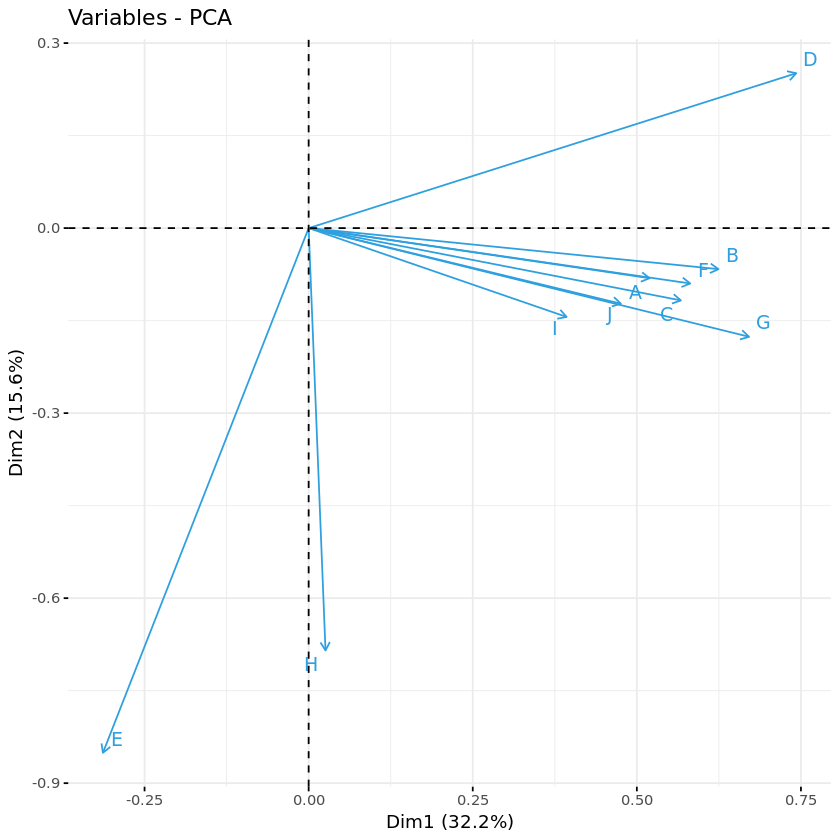

In [12]:
pacman::p_load(factoextra)

# Biplot
fviz_pca_var(pca, repel = TRUE,
                col.var = "#2E9FDF", # Variables color
                col.ind = "#696969"  # Individuals color
                )

Now let's actually grap the first principal component and standardize it

In [13]:
# Take first principal component and standardize
kp$pc1 <- scale(pca$x[,1])

Now that we've constructed our data, let's merge it together and look at the correlations between mental health and community participation

In [14]:
df <- merge(kp, pm, by = c('hhid14_9','pid14'))

Before going further, we're gonna merge in some demographic characteristics

In [15]:
# Individual level demographic data
ar1 <- read_dta('bk_ar1.dta')


# Select variables and merge in
demogs <- ar1 %>% select(hhid14_9, pid14, ar07, ar09,ar15, ar15d, ar15a, ar17) #Sex, Age, Religion, Ethnicity, Whether they worked in last 12 months, Schooling

df <- merge(df, demogs, by = c('hhid14_9','pid14'))

In [16]:
# Recode female from 3 to 0
df$ar07 <- 1*(df$ar07==1)

## Exporting Regression Tables

`stargazer` is a package that is going to make your life a lot easier. First you create regression objects, then it will format a table that you can write as text, Latex, or HTML, where you can adjust the labels and formatting in a million different ways. Here is a [useful guide](https://www.jakeruss.com/cheatsheets/stargazer/).

In [17]:
# Run regressions (note the clustering)
res <- felm(spent_time~scale(pc1)|0|0|hhid14_9, data = df) 
res1<- felm(spent_time~scale(pc1)+ar17+factor(ar15)+ar07+ar09|0|0|hhid14_9, data = df)
res2 <- felm(spent_time~(tot)|0|0|hhid14_9, data = df) 
res3<- felm(spent_time~(tot)+ar17+factor(ar15)+ar07+ar09|0|0|hhid14_9, data = df) 
res4 <- felm(activities~scale(pc1)|0|0|hhid14_9, data = df) 
res5 <- felm(activities~scale(pc1)+ar17+factor(ar15)+ar07+ar09|0|0|hhid14_9, data = df)

In [18]:
stargazer(res, res1,res2, res3,res4, res5, type = 'text',  # Regression objects and type of output
         order = c('pc1','tot'), # Choose order for the variables
         keep = c('pc1','tot', 'ar17','ar07','ar09'), # Choose which variables to keep
         covariate.labels = c('Mental Health Index',"Avg. days with symptoms",'Highest Grade', 'Sex','Age'), # Label RHS variables
         dep.var.labels = c("# of Activities w/ Time Spent","# of Activities w/ any Participation"), # Label different outcome variables
         keep.stat = c('n','rsq','adj.rsq'), # Choose which stats to keep
         out = 'table1.html') # write to output file


                                                   Dependent variable:                           
                        -------------------------------------------------------------------------
                                     # of Activities w/ Time Spent              # of Activities w/ any Participation
                          (1)          (2)                (3)            (4)      (5)      (6)   
-------------------------------------------------------------------------------------------------
Mental Health Index     0.022**      0.076***                                   0.018*  0.087*** 
                        (0.010)      (0.010)                                    (0.011)  (0.011) 
                                                                                                 
Avg. days with symptoms                                -0.028***        0.008                    
                                                        (0.010)        (0.010)                   


Now let's look at the correlations between individual symptoms and community participation.

In [19]:
# Make variables factors
df$A <- factor(df$A)
df$B <- factor(df$B)
df$C <- factor(df$C)
df$D <- factor(df$D)
df$E <- factor(df$E)

# Run regressions (annoying trick to get stargazer to produce all the output on the same rows)
df$var <- df$A
resA <- felm(spent_time~var|0|0|hhid14_9, data = df) 
df$var <- df$B
resB<- felm(spent_time~var|0|0|hhid14_9, data = df) 
df$var <- df$C
resC <- felm(spent_time~var|0|0|hhid14_9, data = df) 
df$var <- df$D
resD<- felm(spent_time~var|0|0|hhid14_9, data = df) 
df$var <- df$E
resE <- felm(spent_time~var|0|0|hhid14_9, data = df) 

In [20]:
stargazer(resA, resB, resC, resD, resE, type = 'text', # Regression objects and type of output
         covariate.labels = c("Sometimes","Occasionally","Most of the Time"), # Labels for covariates
         omit = 'Constant', # Variables to drop
         dep.var.labels = "# Activities Spent Time On", # Label dependent variable
         keep.stat = c('n','rsq','adj.rsq'), # Choose which stats to keep
         out = 'table2.html', # Optional file to write to
         column.labels = c("Unusually Bothered","Low Concentration","Depressed","Effort","Not Hopeful")) # Name each column with the indicator we're checking


                                         Dependent variable:                        
                 -------------------------------------------------------------------
                                     # Activities Spent Time On                     
                 Unusually Bothered Low Concentration Depressed  Effort  Not Hopeful
                        (1)                (2)           (3)      (4)        (5)    
------------------------------------------------------------------------------------
Sometimes              0.023             -0.038        -0.034    0.006    -0.070*** 
                      (0.026)            (0.025)       (0.028)  (0.026)    (0.025)  
                                                                                    
Occasionally          0.077***           0.048*         0.036   0.206***  -0.127*** 
                      (0.029)            (0.029)       (0.034)  (0.029)    (0.027)  
                                                                

## Plotting
`ggplot2` is the go-to package to make nice plots. Here we make a scatter and a bar plot as examples. The idea is to set up a `ggplot` object and then add stuff to it. First we'll do a scatter plot of our mental health index by age, with separate colors for men and women, and a linear fit.

`geom_smooth()` using formula = 'y ~ x'
Saving 6.67 x 6.67 in image
`geom_smooth()` using formula = 'y ~ x'


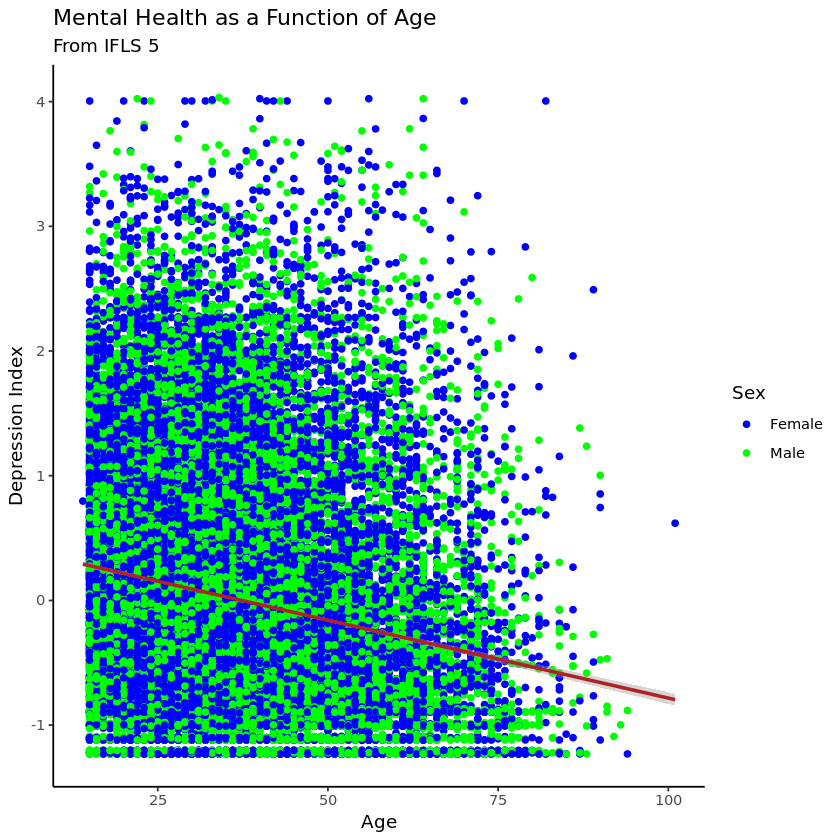

In [21]:
# Create the base of the plot
g <- ggplot(aes(x=ar09, y=pc1,color = factor(ar07)), data = df)
# Scatter points and add regression line
g<- g+ geom_point() + geom_smooth(method="lm",color = 'firebrick') 
# Label stuff
g <- g + labs(title = "Mental Health as a Function of Age", subtitle="From IFLS 5",  x="Age" , y="Depression Index", color = 'Sex')
# Adjust theme and colors
g + theme_classic() + scale_color_manual(labels = c("Female", "Male"), values = c("blue", "green")) 
ggsave("pc1_age_bysex.png")

Now let's do a bar graph of our mental health index by sex

Saving 6.67 x 6.67 in image


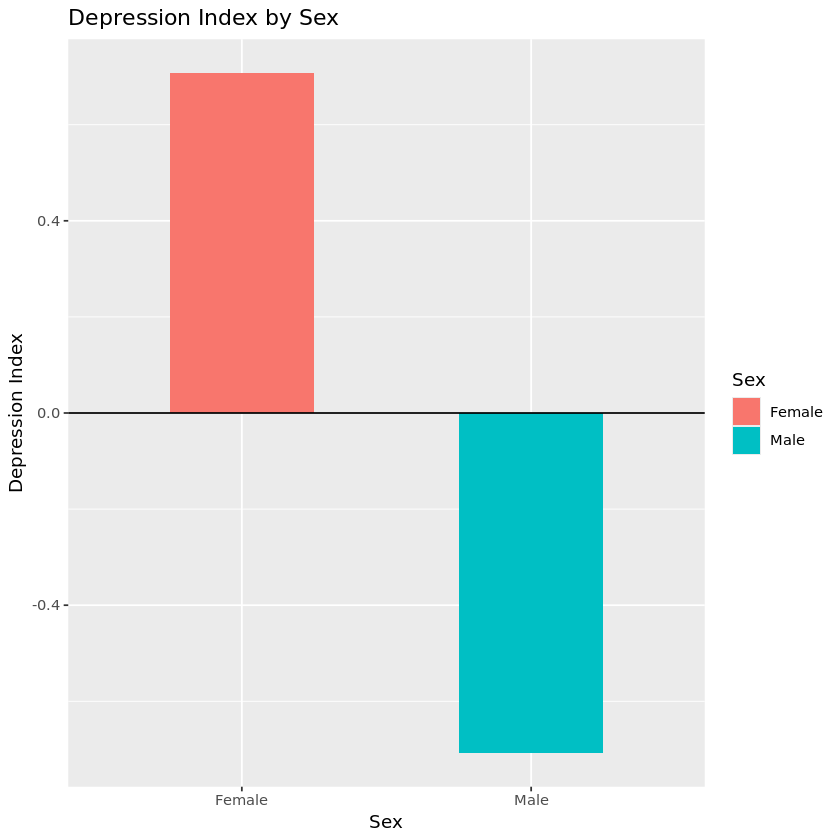

In [22]:
# Take average of mental health index by sex
gb <- df %>% group_by(ar07) %>% summarize(pc1 = mean(pc1, na.rm=T))
gb$sex <- factor(gb$ar07, labels = c("Female", "Male"))

# Set up new graph
g <- ggplot(aes(x=sex, y=scale(pc1),fill = sex), data = gb )
# Add bar chart with line at 0
g + geom_col(width = .5) + labs(title = 'Depression Index by Sex', y = 'Depression Index',x = "Sex", fill= 'Sex') + geom_hline(yintercept= 0)
ggsave("pc1_by_sex.png")

A useful source to check out if you want to make other types of (prettier) plots is the [R Graphics Cookbook](https://r-graphics.org/)